# N-Tuple Learning with Monte Carlo methods

Created 2025-07-17

*Summary*: The original n-tuple network was not working well. The idea is to switch to MC and try some new ideas:
- Instead of TD learning, use Monte Carlo methods and train the model _after_ the episode
    - This should also increase the training speed
- Predict the value function instead of the action value function
- Update towards the final reward (and not the reward from step n to n+1).
    - May fix the problem that the agent is prefering low merges due to immediate reward, while the optimal solution is mostly to wait for a higher merge
    - Combined with the switch to a value function the score gets a meaning: The average score given the current board

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 Agent and network

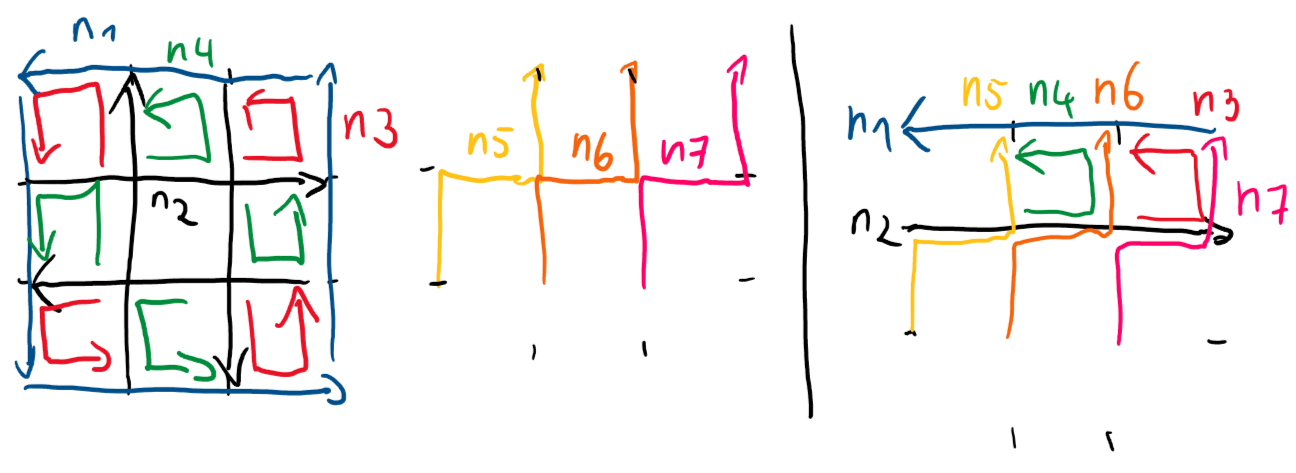

In [ ]:
def extract_tuples(grid: np.ndarray):
    """
    Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
    (n, ||n_tuple||, 4, 4) = (n, 7, 4, 4) \n
    with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
    """
    assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
    n_tuples = np.zeros(shape=(grid.shape[0],7,4,4), dtype=grid.dtype)
    for k in range(4):
        g_v = np.rot90(grid, k=k, axes=(1,2))
        n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
        n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
        n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
        n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
        n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
        n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
        n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
    return n_tuples

extract_tuples(np.arange(0,16).reshape(1,4,4)).shape

(1, 7, 4, 4)

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)

        self.c1 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,2))
        self.c2 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,2))
        self.c3 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,3))
        self.c4 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,4))

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,1)), # (n,7,4,4) -> (n,7,4,4)
            nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,4)), # (n,7,4,4) -> (n,7,4,1)
            nn.Flatten(), # (n,7,4,1) -> (n,28)
            nn.Linear(in_features=28, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Linear(in_features=64, out_features=1),
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,7,4,4) """
        return self.net.forward(x)
    
    def V(self, x: np.ndarray) -> np.ndarray:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, :]
        x = self.extract_tuples(x) # (n,4,4) -> (n,7,4,4)
        t = torch.from_numpy(x).float().to(self.device)
        with torch.no_grad():
            vs = self.forward(t)
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, ||n_tuple||, 4, 4) = (n, 7, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],7,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
        return n_tuples

In [ ]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 200

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0].squeeze(1)
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, epsilon=0.5, epsilon_decay=0.005, gamma=0.99)
scores = []
highest_tiles = []
move_counts = []
episode = -1